In [1]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.facecolor'] = "white"

from reservoir import reservoir as res
from data import data
from error import error

Generate some test data.

In [2]:
# time step size
DEL_T = 0.01

In [3]:
lorenz_data = data.generate_lorenz_63(params=[10, 28, -8/3], 
                                      initial_state=[1, 1, 1], del_t=DEL_T,
                                      steps=30000, washout=10000)
print(lorenz_data)
print(lorenz_data.shape)
training_data = lorenz_data[:lorenz_data.shape[0] // 2]
test_data = lorenz_data[lorenz_data.shape[0] // 2:]

[[ -8.47965722 -14.5123554   15.72421705]
 [ -9.09696196 -15.40313805  16.60822317]
 [ -9.73928527 -16.26936278  17.64384007]
 ...
 [ -9.63164986  -0.84252354  36.6800054 ]
 [ -8.75710572  -0.08145599  35.7558209 ]
 [ -7.90106831   0.52294291  34.79606715]]
(20000, 3)


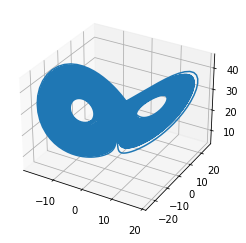

In [4]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    lorenz_data[:, 0],
    lorenz_data[:, 1],
    lorenz_data[:, 2]
)

Define hyperparameters, number of reservoir nodes ($N$), and the dimension of 
the input signal ($d$).

In [5]:
hyperparams = {
    'GAMMA': 9,
    'SIGMA': 0.5,
    'RHO_IN': 1,
    'K': 3,
    'RHO_R': 1
}

# number of reservoir nodes
N = 100
# dimension of input signal
d = 3

Construct internal connection network and input signal connection network. 

In [6]:
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), seed=42)
# print(W_in)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), seed=42)
# print(W_r)

Train reservoir on training data points. 

Suppose we have a training data set 
$$
    \mathcal{U} = (\mathbf{u}(\tau_0), \dots \mathbf{u}(\tau_n))
$$
where each $\mathbf{u}_i \in \reals^3$ and $\tau_0,\dots,\tau_n$ are the time steps. 

Construct the reservoir 
$$
    \mathcal{R} = (\mathbf{r}(\tau_0), \dots \mathbf{r}(\tau_n))
$$
using:
$$
    \mathbf{r}(\tau_0) = W_{\text{in}} \mathbf{u}(\tau_0)
$$
and 
$$
    \mathbf{r}(\tau_{n+1}) = \mathbf{r}(\tau_n) + \dot{\mathbf{r}}(\tau_n)\Delta \tau.
$$

In [7]:
# compute number of time steps
n = training_data.shape[0]

# initial signal
u_0 = training_data[0]
# initial reservoir state
r_0 = np.dot(W_in, u_0)

# initialise echo state network
training_res = np.ndarray((n, N))
# fill in echo state network
for i in range(n):
    # first reservoir is unique (as it has no previous state)
    if i == 0:
        training_res[i] = r_0
    # next reservoir is dependent on reservoir dynamics
    else: 
        training_res[i] = res.next_training_node(
            r_prev=training_res[i-1],
            u_prev=training_data[i-1],
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            delta_t=DEL_T
        )

Given a reservoir $\mathcal{R}$, we compute 
$$
    \tilde{\mathcal{R}} = (\tilde{\mathbf{r}}(\tau_0), \dots \tilde{\mathbf{r}}(\tau_n))
$$
where the components of any $\tilde{\mathbf{r}}(\tau_k)$ are given by:
$$
    \tilde{r}_i(\tau_k) = \begin{cases}
        r_i(\tau_k)      &\quad\text{if $i \leq \frac{N}{2}$} \\
        r_i(\tau_k)^2    &\quad\text{if $i > \frac{N}{2}$}
    \end{cases}
$$

In [8]:
# modify training reservoir network to account for symmetry
modified_training_res = np.ndarray((n, N))

for k in range(n):
    node = training_res[k]
    modified_node = np.ndarray(N)
    for i in range(N):
        if i <= N / 2:
            modified_node[i] = node[i]
        else:
            modified_node[i] = node[i] ** 2
    modified_training_res[k] = modified_node

modified_training_res

array([[ 9.18804627e+00, -1.46649570e+01, -5.97953472e-01, ...,
         1.02176561e+00,  6.95519203e+01,  0.00000000e+00],
       [ 8.27269883e+00, -1.32551118e+01, -6.34137660e-01, ...,
         1.01798465e+00,  5.62404785e+01,  8.10000000e-03],
       [ 7.47318364e+00, -1.19723578e+01, -6.67065270e-01, ...,
         1.01434126e+00,  4.54145586e+01,  2.95496100e-02],
       ...,
       [-3.33241090e-01,  9.92256060e-01, -9.99993920e-01, ...,
         5.99582891e-01,  8.12650270e-01,  3.63163900e-01],
       [-3.87798150e-01,  9.92953015e-01, -9.99994467e-01, ...,
         6.22562037e-01,  8.28716666e-01,  3.63112773e-01],
       [-4.38700941e-01,  9.93587244e-01, -9.99994965e-01, ...,
         6.41897219e-01,  8.43473761e-01,  3.63016797e-01]])

In [9]:
test_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)
print(sum(sum(modified_training_res - test_res[0])))
print(sum(sum(training_res - test_res[1])))

61993.88626288782
-1541.4828219789927


In [10]:
# design matrix
X = test_res[0]
# Tikhonov regularisation parameter
ALPHA = 0.01
# analytic solution
W_out = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X) + ALPHA * np.identity(N)), X.transpose()), training_data)

In [11]:
preds = np.ndarray(training_data.shape)
for i in range(n):
    preds[i] = np.dot(W_out.transpose(), X[i])
preds

array([[ -2.2184184 ,  -3.9831029 ,   7.93192329],
       [ -5.70863265,  -9.19104399,  12.21249488],
       [ -8.3377541 , -12.96748438,  15.57022223],
       ...,
       [ 15.8955175 ,  18.27609319,  33.77352764],
       [ 16.16488117,  17.27861139,  35.72875914],
       [ 16.39567536,  16.27298406,  37.57185493]])

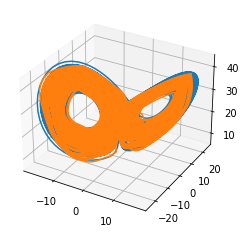

In [12]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.plot(
    training_data[:, 0],
    training_data[:, 1],
    training_data[:, 2]
)
plt.plot(
    preds[:, 0],
    preds[:, 1],
    preds[:, 2]
)

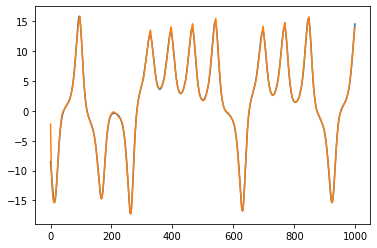

In [13]:
fig = plt.figure()
plt.plot(training_data[0:1000, 0])
plt.plot(preds[0:1000, 0])

We have now completed the training stage, and generated:
- `X`, the reservoir generated using the training data (input signals $\mathcal{U}$)
- `W_out`, the output layer which best approximates
$$
    \mathbf{u}(\tau_n) \approx W_{\text{out}} \tilde{\mathbf{r}}(\tau_n)
$$
computed using Tikhonov regularisation. 

In the forecasting (testing) stage, we make a modification to the reservoir 
dynamics in order to make the reservoir autonomous. In particular, set the 
reservoir dynamics to:
$$
    \dot{\mathbf{r}}(t) = -\gamma \mathbf{r}(t) + \gamma \tanh(W_r \mathbf{r}(t) + W_{\text{in}}W_{\text{out}}\tilde{\mathbf{r}}(t)).
$$
and in summary, the forecast reservoir is generated using:
$$
    \mathbf{r}(\tau_0) = \mathbf{u}(\tau_0)
$$
and 
$$
    \mathbf{r}(\tau_{n+1}) = \mathbf{r}(\tau_n) + \dot{\mathbf{r}}(\tau_n)\Delta \tau.
$$

In [14]:
# def next_forecast_res(r_prev, hyperparams, W_r, W_in, W_out, delta_t):
#     GAMMA = hyperparams["GAMMA"]

#     return r_prev + delta_t * ((-GAMMA) * r_prev)

In [15]:
# n = test_data.shape[0]
# N = W_r.shape[0]

# # initial reservoir state
# r_0 = np.dot(W_in, test_data[0])

# forecast_res = np.ndarray((n, N))

# for i in range(n):
#     if i == 0:
#         # first reservoir is unique (as it has no previous state)
#         forecast_res[i] = r_0
#     else:
#         forecast_res[i] = next_forecast_res(

#         )